In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
from replay_buffer import ReplayBuffer
import numpy as np
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node

Delay_VoltageSampling = np.array([0,0,0,0,0, 10,10,10,10,10,10,10,10,10,10,10,10,10, 0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
Origin_Load = LoadSeconds
Origin_Generation = GenerationSeconds

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...


In [2]:
############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1, solar_irr, VBP, Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def adaptive_control(delay, vk, vkmdelay, ukmdelay, thresh, yk):
    if (yk > thresh):
        uk = delay/2*k * ( vk**2 + vkmdelay**2 ) + ukmdelay
    else:
        uk = ukmdelay
    return uk

In [3]:
#support function
def processing_state(V, G, L):
    state = np.array([V, G, L]).T
    result = np.zeros((60,3))
    result[:state.shape[0],:state.shape[1]] = state #padding with zeros
    state = result.copy()
    return state

In [4]:
#this is the agent
import tensorflow as tf
EPS = 1e-6

def build_graph(inputs, layer_sizes, non_linearlayer=False):
    if type(inputs) is tf.Tensor:
        inputs = [inputs]
    
    with tf.variable_scope('layer0'):
        state = inputs[0]
        rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=32)
        outputs, states = tf.nn.dynamic_rnn(rnn_cell, state, dtype=tf.float32)
        state0 = tf.layers.dense(states, 30)
        if len(inputs) != 1:
            action = inputs[1]
            action0 = tf.layers.dense(action, 30)
            layer = action0 + state0
        else: 
            layer = state0
        layer = tf.nn.relu(layer)
    
    for i_layer, size in enumerate(layer_sizes, 1):
        with tf.variable_scope('layer{0}'.format(i_layer)):
            layer = tf.layers.dense(layer, size)
            if i_layer < len(layer_sizes) - 1:
                layer = tf.nn.relu(layer)
    
    if non_linearlayer==True:
        layer = tf.nn.tanh(layer)
    
    return layer

class NNFunction():
    def __init__(self, name, input_pls, hidden_layer_sizes):
        self._name = name
        self._input_pls = input_pls
        if name != 'policy':
            self._layer_sizes = list(hidden_layer_sizes) + [1]
        else:
            self._layer_sizes = list(hidden_layer_sizes) + [4]
        self._output_t = self.get_output_for(*self._input_pls)
    def get_output_for(self, *inputs, reuse=False):
        with tf.variable_scope(self._name, reuse=reuse):
            value_t = build_graph(inputs=inputs, layer_sizes=self._layer_sizes)
        return value_t
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )

class NNQFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30,30), name='qf'):
        self._Da = 4
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None]+ self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        super(NNQFunction, self).__init__(name, (self._obs_pl, self._action_pl), hidden_layer_sizes)

#############################################################        
    
class Policy(NNFunction):
    def __init__(self, hidden_layer_sizes=(30,30), reparameterize=False, name='policy', squash=True):
        self._name = name
        self._Do = [60,3]
        self._Da = 4
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        self._layer_sizes = hidden_layer_sizes
        super(Policy, self).__init__(name, (self._obs_pl,), hidden_layer_sizes)
        
    def actions_for(self, observations, reuse=tf.AUTO_REUSE):
        name = self._name
        with tf.variable_scope(name, reuse=reuse):
            actions = build_graph(inputs=observations, layer_sizes=self._layer_sizes, non_linearlayer=True)        
        return actions    
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
    def _squash_correction(self, actions):
        if not self._squash: return 0
        return tf.reduce_sum(tf.log(1 - tf.tanh(actions) ** 2 + EPS), axis=1)
    
    def name(self):
        return self._name

class agent():
    def __init__(self, sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph, name='agent'):
        self._observations_ph = observations_ph
        self._next_observations_ph = next_observations_ph
        self._rewards_ph = rewards_ph
        self._actions_ph= actions_ph
        self._terminals_ph = terminals_ph
        
        self._discount = 0.99
        self._tau = 0.01
        
        self._qf_lr = 0.1
        self._vf_lr = 0.1
        self._policy_lr = 0.01
        self._action_prior = 'Normal'
        self._reparameterize = False
        self._sess = sess
        self._training_ops = []
        
        with tf.variable_scope(name):
            self._qf = NNQFunction((30,30), 'qf')
            self._policy = Policy(hidden_layer_sizes=(30,30))
            self._init_critic_update()
            self._init_actor_update()
            self._init_target_ops()
            
        uninit_vars = []
        for var in tf.global_variables():
            try:
                self._sess.run(var)
            except tf.errors.FailedPreconditionError:
                uninit_vars.append(var)
        self._sess.run(tf.variables_initializer(uninit_vars))
        
        self._init_training()
        
    def _init_critic_update(self):
        self._qf_t = self._qf.get_output_for(self._observations_ph, self._actions_ph, reuse=True)
        
        with tf.variable_scope('target_policy'):
            actions = self._policy.actions_for(self._next_observations_ph)
            self._policy_target_params = self._policy.get_params_internal()
        
        with tf.variable_scope('target_qf'):
            self._qf_t_next = self._qf.get_output_for(self._next_observations_ph, actions)        
            self._qf_target_params = self._qf.get_params_internal()
        ys = tf.stop_gradient(
            self._rewards_ph +
            (1 - self._terminals_ph) * self._discount * self._qf_t_next)  
        
        self._td_loss_t = 0.5 * tf.reduce_mean((ys - self._qf_t)**2)
        qf_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss_t,
            var_list=self._qf.get_params_internal()
        )
        self._training_ops.append(qf_train_op)
        
    def _init_actor_update(self):
        self._action = self._policy.actions_for(self._observations_ph, reuse=True)
        self._policy_params = self._policy.get_params_internal()
        self._qf_t = self._qf.get_output_for(self._observations_ph, self._actions_ph, reuse=True)
        self._qf_params = self._qf.get_params_internal()
        
        q_grads = tf.negative(tf.gradients(self._qf_t, self._actions_ph))
        grads = tf.gradients(self._action, self._policy_params, q_grads)
        
        grads = list(map(lambda x: tf.div(x, 30), grads))
        policy_train_op = tf.train.AdamOptimizer(self._policy_lr).apply_gradients(zip(grads, self._policy.get_params_internal()))
        self._training_ops.append(policy_train_op)        
        
    def _init_target_ops(self):
        """Create tensorflow operations for updating target value function."""

        source_params = self._qf_params
        target_params = self._qf_target_params
        
        self._target_ops_qf = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]
        
        source_params_p = self._policy_params
        target_params_p = self._policy_target_params

        self._target_ops_p = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params_p, source_params_p)
        ]

    def _init_training(self):
        self._sess.run(self._target_ops_qf)
        self._sess.run(self._target_ops_p)

    def do_training(self, batch):
        """Runs the operations for updating training and target ops."""

        feed_dict = self._get_feed_dict(batch)
        self._sess.run(self._training_ops[0], feed_dict)
        self._sess.run(self._training_ops[1], feed_dict)
        self._sess.run(self._target_ops_qf)
        self._sess.run(self._target_ops_p)

    def _get_feed_dict(self, batch):
        """Construct TensorFlow feed_dict from sample batch."""

        feed_dict = {
            self._observations_ph: batch['observations'],
            self._actions_ph: batch['actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_ph: batch['rewards'],
            self._terminals_ph: batch['terminals'],
        }
        return feed_dict
   
    def action_respond(self, obs):
        action = self._action
        a = self._sess.run([action], feed_dict={observations_ph: obs})[0][0]
        return a
    
def init_placeholder():
    observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='observation')
    next_observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='next_observation')
    rewards_ph = tf.placeholder(tf.float32, shape=(None, 1), name='reward')
    actions_ph = tf.placeholder(tf.float32, shape=(None, 4), name='action')
    terminals_ph = tf.placeholder(tf.float32, shape=(None, 1), name='terminal')
    return observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph

D:\Apps\Anacoda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
sess = tf.Session()
agent = agent(sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph)

In [ ]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.005, theta=.1, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)
    

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


D:\Apps\Anacoda3\lib\site-packages\ipykernel_launcher.py:256: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


-315130.0739786803
--- 62.3885064125061 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


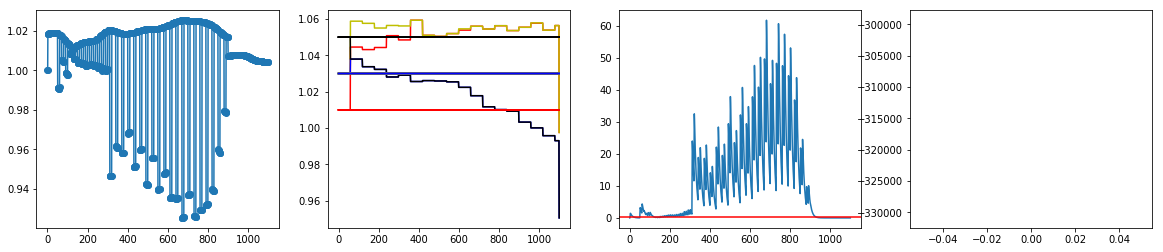

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.5400502681732178 seconds ---
--- 0.02598738670349121 seconds ---
--- 0.02133917808532715 seconds ---
--- 0.020229101181030273 seconds ---
--- 0.030646324157714844 seconds ---
--- 0.020184993743896484 seconds ---
--- 0.022357702255249023 seconds ---
-7041.77360253357
--- 69.96881651878357 seconds ---


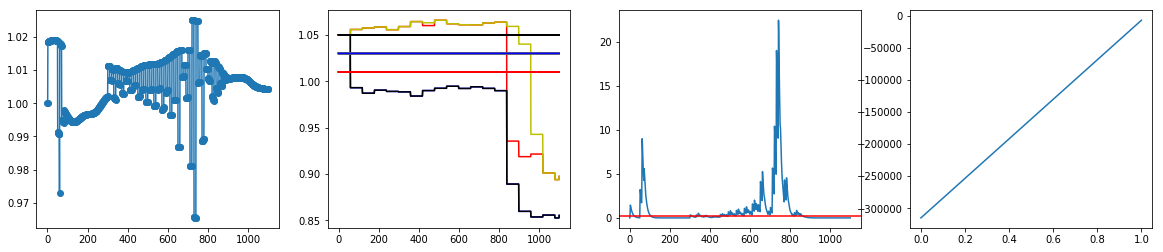

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.02016592025756836 seconds ---
--- 0.02672600746154785 seconds ---
--- 0.02219700813293457 seconds ---
--- 0.02831578254699707 seconds ---
--- 0.029442787170410156 seconds ---
--- 0.023626089096069336 seconds ---
--- 0.030078887939453125 seconds ---
--- 0.027649641036987305 seconds ---
--- 0.02086615562438965 seconds ---
--- 0.01982593536376953 seconds ---
--- 0.02131509780883789 seconds ---
--- 0.021867752075195312 seconds ---
--- 0.0201418399810791 seconds ---
--- 0.024005413055419922 seconds ---
--- 0.020186185836791992 seconds ---
--- 0.02207636833190918 seconds ---
--- 0.01915431022644043 seconds ---
--- 0.01932382583618164 seconds ---
--- 0.023224592208862305 seconds ---
-1314.2881846358289
--- 82.90068483352661 seconds ---


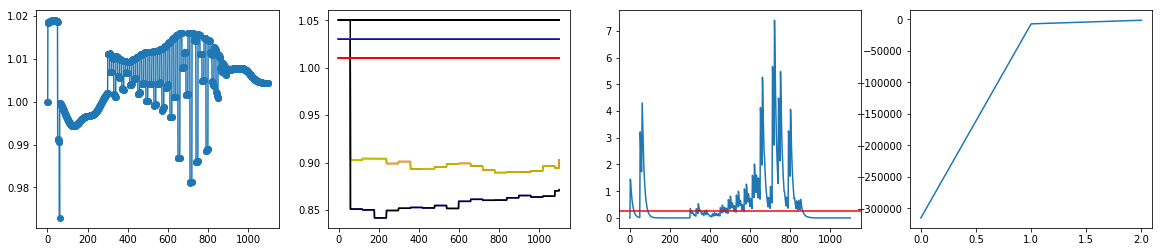

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.02722334861755371 seconds ---
--- 0.024359464645385742 seconds ---
--- 0.026819467544555664 seconds ---
--- 0.020081043243408203 seconds ---
--- 0.022170066833496094 seconds ---
--- 0.021280288696289062 seconds ---
--- 0.020162105560302734 seconds ---
--- 0.028400182723999023 seconds ---
--- 0.01898360252380371 seconds ---
--- 0.020139694213867188 seconds ---
--- 0.020160198211669922 seconds ---
--- 0.022412538528442383 seconds ---
--- 0.03279256820678711 seconds ---
--- 0.024215221405029297 seconds ---
--- 0.02230548858642578 seconds ---
--- 0.02104496955871582 seconds ---
--- 0.02017354965209961 seconds ---
--- 0.020679712295532227 seconds ---
--- 0.020149946212768555 seconds ---
-1314.2881846358289
--- 81.32030916213989 seconds ---


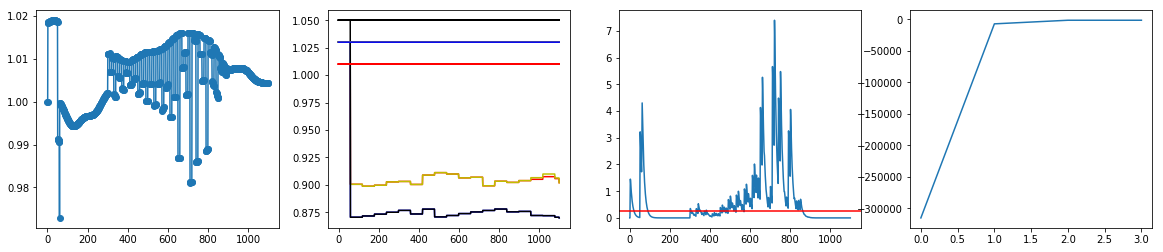

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.020291805267333984 seconds ---
--- 0.020290613174438477 seconds ---
--- 0.022757291793823242 seconds ---
--- 0.028261899948120117 seconds ---
--- 0.021419525146484375 seconds ---
--- 0.02017498016357422 seconds ---
--- 0.01999807357788086 seconds ---
--- 0.02193760871887207 seconds ---
--- 0.022226810455322266 seconds ---
--- 0.02331256866455078 seconds ---
--- 0.021908283233642578 seconds ---
--- 0.026304244995117188 seconds ---
--- 0.029499530792236328 seconds ---
--- 0.02028036117553711 seconds ---
--- 0.023743152618408203 seconds ---
--- 0.020198822021484375 seconds ---
--- 0.027459383010864258 seconds ---
--- 0.030104875564575195 seconds ---
--- 0.02142953872680664 seconds ---
-1314.2881846358289
--- 84.08787727355957 seconds ---


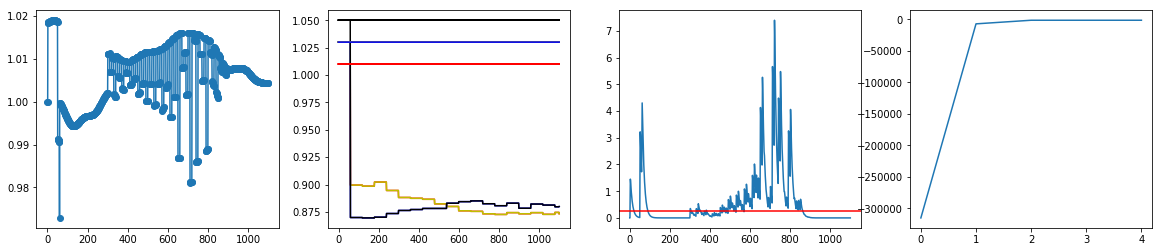

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0240786075592041 seconds ---
--- 0.0224759578704834 seconds ---
--- 0.021250247955322266 seconds ---
--- 0.031676530838012695 seconds ---
--- 0.026203393936157227 seconds ---
--- 0.0219573974609375 seconds ---
--- 0.019914627075195312 seconds ---
--- 0.025447607040405273 seconds ---
--- 0.02527332305908203 seconds ---
--- 0.022172212600708008 seconds ---
--- 0.024529457092285156 seconds ---
--- 0.022207021713256836 seconds ---
--- 0.0221865177154541 seconds ---
--- 0.02401447296142578 seconds ---
--- 0.024914979934692383 seconds ---
--- 0.024195432662963867 seconds ---
--- 0.01902031898498535 seconds ---
--- 0.02466607093811035 seconds ---
--- 0.019968509674072266 seconds ---
-1314.2881846358289
--- 81.77891993522644 seconds ---


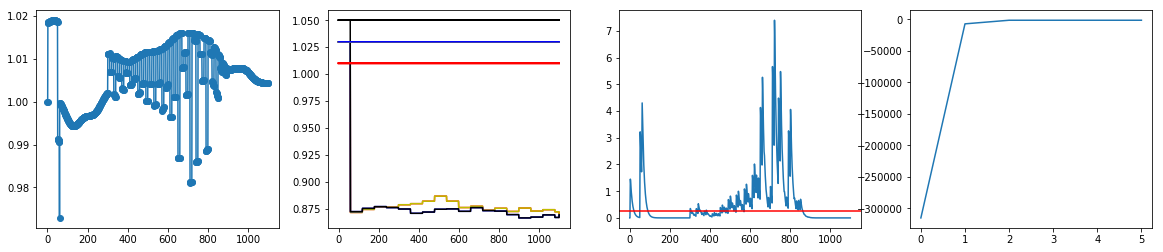

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.025043725967407227 seconds ---
--- 0.022825002670288086 seconds ---
--- 0.02497553825378418 seconds ---
--- 0.02355480194091797 seconds ---
--- 0.019517183303833008 seconds ---
--- 0.025214195251464844 seconds ---
--- 0.027193307876586914 seconds ---
--- 0.025537967681884766 seconds ---
--- 0.018975496292114258 seconds ---
--- 0.021600008010864258 seconds ---
--- 0.025067567825317383 seconds ---
--- 0.018076419830322266 seconds ---
--- 0.019974708557128906 seconds ---
--- 0.028051137924194336 seconds ---
--- 0.02001500129699707 seconds ---
--- 0.02117919921875 seconds ---
--- 0.022519826889038086 seconds ---
--- 0.025475025177001953 seconds ---
--- 0.02250981330871582 seconds ---
-1314.2881846358289
--- 81.432133436203 seconds ---


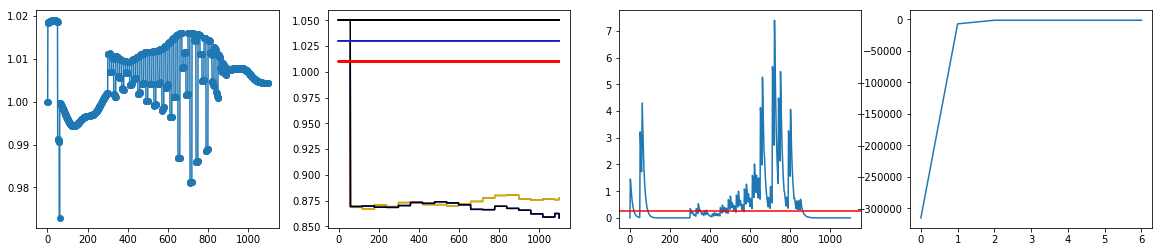

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.02278923988342285 seconds ---
--- 0.023399829864501953 seconds ---
--- 0.02073192596435547 seconds ---
--- 0.013960123062133789 seconds ---
--- 0.016954421997070312 seconds ---
--- 0.01595759391784668 seconds ---
--- 0.015957355499267578 seconds ---
--- 0.01005411148071289 seconds ---
--- 0.03789806365966797 seconds ---
--- 0.015956401824951172 seconds ---
--- 0.010053157806396484 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.01795172691345215 seconds ---
--- 0.015956878662109375 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.012965202331542969 seconds ---
--- 0.01296544075012207 seconds ---
--- 0.014957427978515625 seconds ---
--- 0.01007533073425293 seconds ---
-1314.2881846358289
--- 67.80591201782227 seconds ---


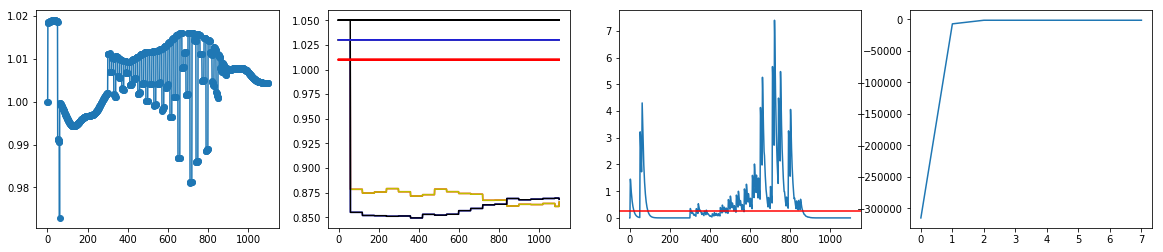

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.01396036148071289 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.020113706588745117 seconds ---
--- 0.020149946212768555 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.020130634307861328 seconds ---
--- 0.012093782424926758 seconds ---
--- 0.01595616340637207 seconds ---
--- 0.020168304443359375 seconds ---
--- 0.014959335327148438 seconds ---
--- 0.01010894775390625 seconds ---
--- 0.01708245277404785 seconds ---
--- 0.012964487075805664 seconds ---
--- 0.013953208923339844 seconds ---
--- 0.013962745666503906 seconds ---
--- 0.010061502456665039 seconds ---
--- 0.010048389434814453 seconds ---
--- 0.010069847106933594 seconds ---
--- 0.018949031829833984 seconds ---
-1314.2881846358289
--- 59.6747932434082 seconds ---


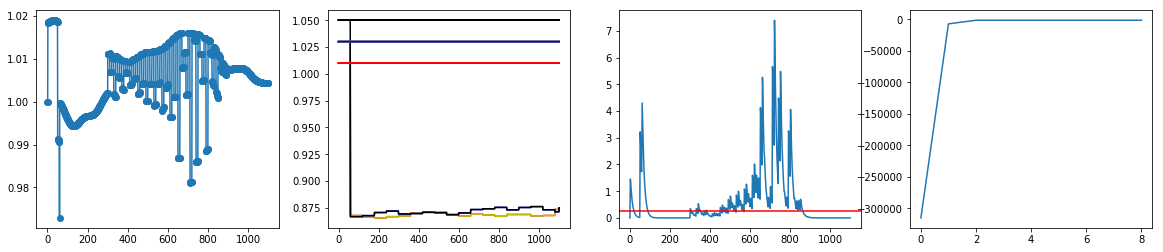

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.01595616340637207 seconds ---
--- 0.010050773620605469 seconds ---
--- 0.01595759391784668 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.012964010238647461 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.013962984085083008 seconds ---
--- 0.01808452606201172 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.012964725494384766 seconds ---
--- 0.013958454132080078 seconds ---
--- 0.01396036148071289 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.01495981216430664 seconds ---
--- 0.012964248657226562 seconds ---
--- 0.014960289001464844 seconds ---
--- 0.014959573745727539 seconds ---
--- 0.018123149871826172 seconds ---
-1314.2881846358289
--- 60.9386727809906 seconds ---


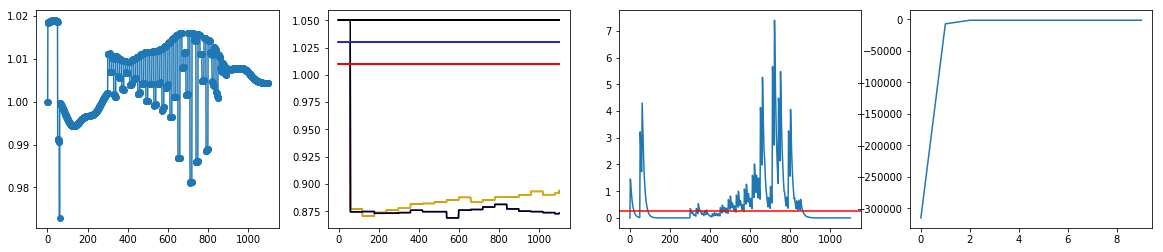

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.010065555572509766 seconds ---
--- 0.01396036148071289 seconds ---
--- 0.016954421997070312 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.015958070755004883 seconds ---
--- 0.013962507247924805 seconds ---
--- 0.020158052444458008 seconds ---
--- 0.01795053482055664 seconds ---
--- 0.014959573745727539 seconds ---
--- 0.01396322250366211 seconds ---
--- 0.015957117080688477 seconds ---
--- 0.01595759391784668 seconds ---
--- 0.014958620071411133 seconds ---
--- 0.015956401824951172 seconds ---
--- 0.01595783233642578 seconds ---
--- 0.014959335327148438 seconds ---
--- 0.0181121826171875 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.012963533401489258 seconds ---
-1314.2881846358289
--- 59.56142830848694 seconds ---


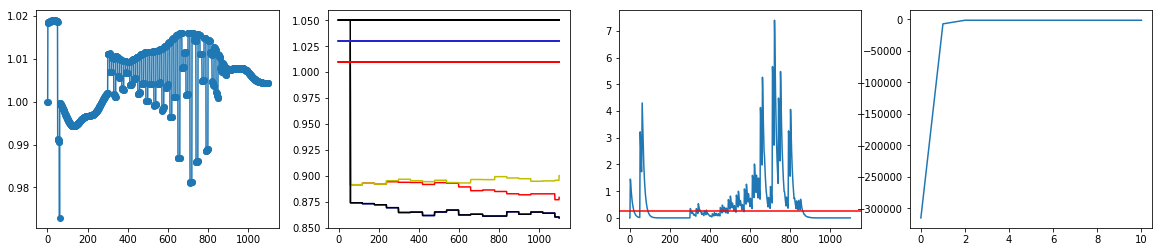

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.018947839736938477 seconds ---
--- 0.009557247161865234 seconds ---
--- 0.012962818145751953 seconds ---
--- 0.013965368270874023 seconds ---
--- 0.013960123062133789 seconds ---
--- 0.01495504379272461 seconds ---
--- 0.014959096908569336 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.016954660415649414 seconds ---
--- 0.015955448150634766 seconds ---
--- 0.01894974708557129 seconds ---
--- 0.01595759391784668 seconds ---
--- 0.01894831657409668 seconds ---
--- 0.015955686569213867 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.01894855499267578 seconds ---
--- 0.015955448150634766 seconds ---
--- 0.014958381652832031 seconds ---
--- 0.014959573745727539 seconds ---
-1314.2881846358289
--- 67.95285892486572 seconds ---


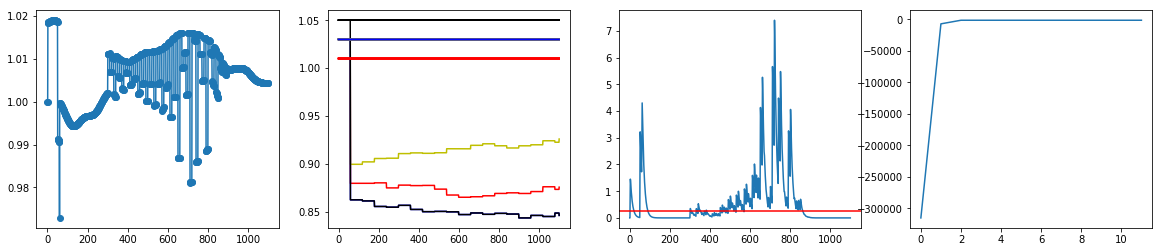

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.012964963912963867 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.015957355499267578 seconds ---
--- 0.010053873062133789 seconds ---
--- 0.016242265701293945 seconds ---
--- 0.012964010238647461 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.014956951141357422 seconds ---
--- 0.012965679168701172 seconds ---
--- 0.010113716125488281 seconds ---
--- 0.012074947357177734 seconds ---
--- 0.013438940048217773 seconds ---
--- 0.015956401824951172 seconds ---
--- 0.015956878662109375 seconds ---
--- 0.010063648223876953 seconds ---
--- 0.010078668594360352 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.01005411148071289 seconds ---
--- 0.015957117080688477 seconds ---
-1314.2881846358289
--- 59.893672466278076 seconds ---


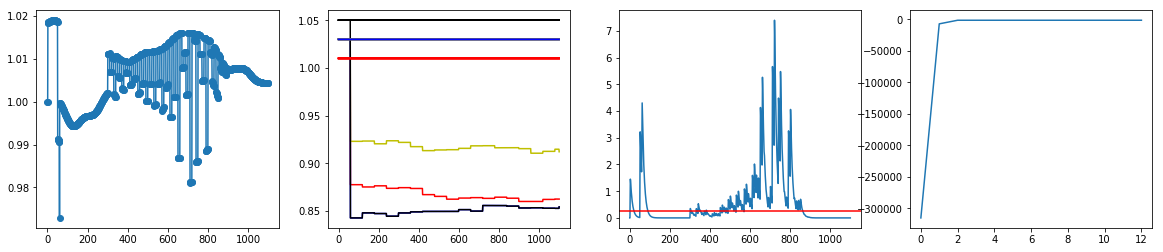

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.01296377182006836 seconds ---
--- 0.018090486526489258 seconds ---
--- 0.015957117080688477 seconds ---
--- 0.020943164825439453 seconds ---
--- 0.011966228485107422 seconds ---
--- 0.016954898834228516 seconds ---
--- 0.020123958587646484 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.020120620727539062 seconds ---
--- 0.012962818145751953 seconds ---
--- 0.015956401824951172 seconds ---
--- 0.013957500457763672 seconds ---
--- 0.012967109680175781 seconds ---
--- 0.013960838317871094 seconds ---
--- 0.014958381652832031 seconds ---
--- 0.012119531631469727 seconds ---
--- 0.012073040008544922 seconds ---
--- 0.02011895179748535 seconds ---
--- 0.020123720169067383 seconds ---
-1314.2881846358289
--- 62.51772713661194 seconds ---


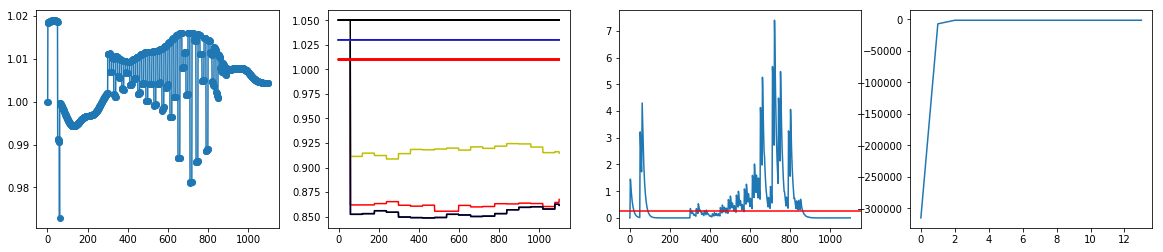

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.015956401824951172 seconds ---
--- 0.013963699340820312 seconds ---
--- 0.01005697250366211 seconds ---
--- 0.014959573745727539 seconds ---
--- 0.017953157424926758 seconds ---
--- 0.014959335327148438 seconds ---
--- 0.012964248657226562 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.013959646224975586 seconds ---
--- 0.012964010238647461 seconds ---
--- 0.013960599899291992 seconds ---
--- 0.016954898834228516 seconds ---
--- 0.01396322250366211 seconds ---
--- 0.014959335327148438 seconds ---
--- 0.013961076736450195 seconds ---
--- 0.012964487075805664 seconds ---
--- 0.013962984085083008 seconds ---
--- 0.014958858489990234 seconds ---
-1314.2881846358289
--- 69.91718316078186 seconds ---


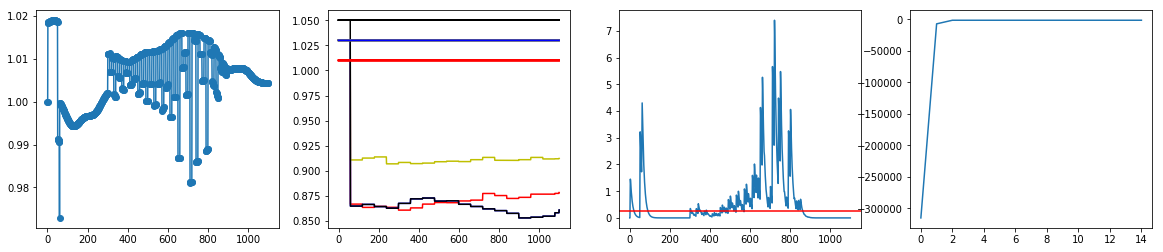

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.015956401824951172 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.014958858489990234 seconds ---
--- 0.021939992904663086 seconds ---
--- 0.013962507247924805 seconds ---
--- 0.013961076736450195 seconds ---
--- 0.014958381652832031 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.012964963912963867 seconds ---
--- 0.012964963912963867 seconds ---
--- 0.012964725494384766 seconds ---
--- 0.012964248657226562 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.015954256057739258 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.013961076736450195 seconds ---
--- 0.0169522762298584 seconds ---
--- 0.014959096908569336 seconds ---
--- 0.014958620071411133 seconds ---
-1314.2881846358289
--- 77.69503474235535 seconds ---


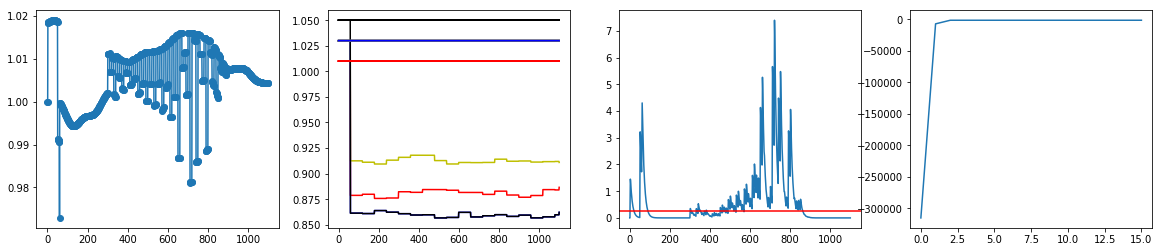

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.014959573745727539 seconds ---
--- 0.014957189559936523 seconds ---
--- 0.014958381652832031 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.015125274658203125 seconds ---
--- 0.010059356689453125 seconds ---
--- 0.014958858489990234 seconds ---
--- 0.013961076736450195 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.01210474967956543 seconds ---
--- 0.010051965713500977 seconds ---
--- 0.01595783233642578 seconds ---
--- 0.016292572021484375 seconds ---
--- 0.012551069259643555 seconds ---
--- 0.017951250076293945 seconds ---
--- 0.014958381652832031 seconds ---
--- 0.014957666397094727 seconds ---
--- 0.0139617919921875 seconds ---
-1314.2881846358289
--- 61.603978633880615 seconds ---


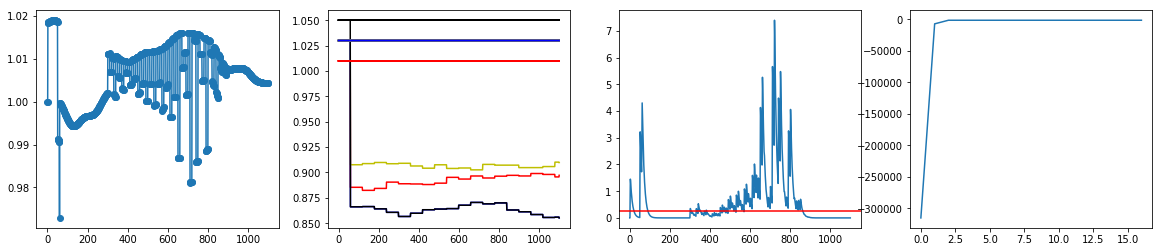

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.013961076736450195 seconds ---
--- 0.020118236541748047 seconds ---
--- 0.012964963912963867 seconds ---
--- 0.014959335327148438 seconds ---
--- 0.01495814323425293 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.015955686569213867 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.018105506896972656 seconds ---
--- 0.0221250057220459 seconds ---
--- 0.012965679168701172 seconds ---
--- 0.01495981216430664 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.01396322250366211 seconds ---
--- 0.013962507247924805 seconds ---
--- 0.012963294982910156 seconds ---
--- 0.013960838317871094 seconds ---
--- 0.012965917587280273 seconds ---
-1314.2881846358289
--- 63.55059885978699 seconds ---


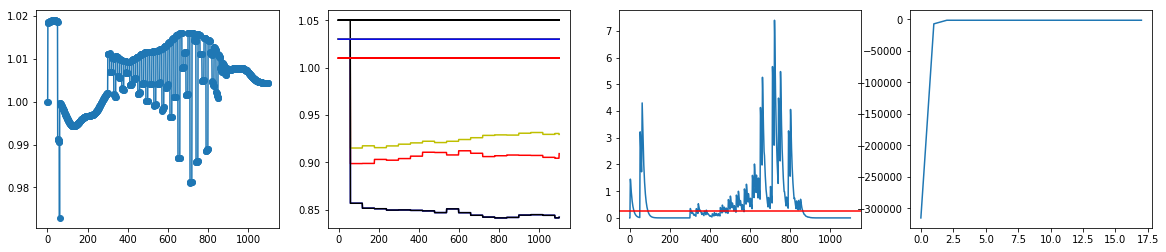

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.013961315155029297 seconds ---
--- 0.01495814323425293 seconds ---
--- 0.014958858489990234 seconds ---
--- 0.013963460922241211 seconds ---
--- 0.013964176177978516 seconds ---
--- 0.014960527420043945 seconds ---
--- 0.012964010238647461 seconds ---
--- 0.015956878662109375 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.019945859909057617 seconds ---
--- 0.013959646224975586 seconds ---
--- 0.013960123062133789 seconds ---
--- 0.012965202331542969 seconds ---
--- 0.015956640243530273 seconds ---
--- 0.016953468322753906 seconds ---
--- 0.014959096908569336 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.012963533401489258 seconds ---
--- 0.015956878662109375 seconds ---
-1314.2881846358289
--- 69.41071677207947 seconds ---


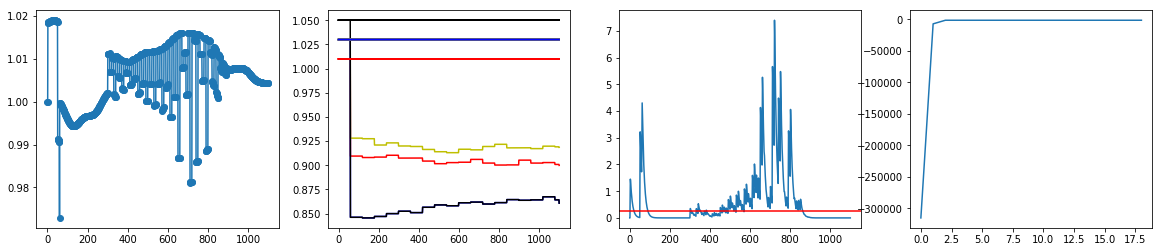

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.015956640243530273 seconds ---
--- 0.018109560012817383 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.014959573745727539 seconds ---
--- 0.015956640243530273 seconds ---
--- 0.02393937110900879 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.01495981216430664 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.013961315155029297 seconds ---
--- 0.015957355499267578 seconds ---
--- 0.013962745666503906 seconds ---
--- 0.013961076736450195 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.015957117080688477 seconds ---
--- 0.01396322250366211 seconds ---
--- 0.01994633674621582 seconds ---
--- 0.0139617919921875 seconds ---
--- 0.013961553573608398 seconds ---
-1314.2881846358289
--- 70.06708002090454 seconds ---


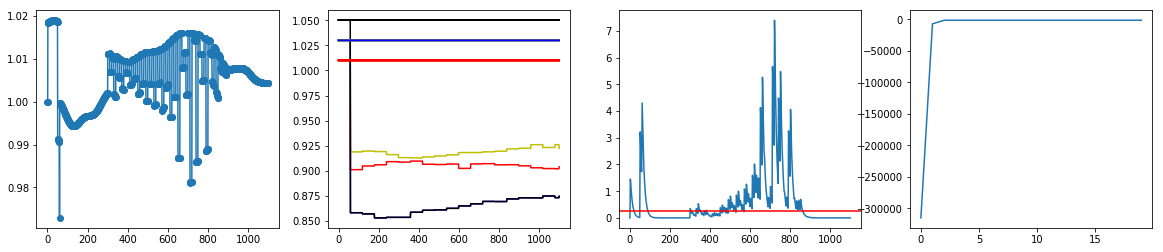

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.013956069946289062 seconds ---
--- 0.013962745666503906 seconds ---
--- 0.012963294982910156 seconds ---
--- 0.01396489143371582 seconds ---
--- 0.01495814323425293 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.015957117080688477 seconds ---
--- 0.0159604549407959 seconds ---
--- 0.01296377182006836 seconds ---
--- 0.015955448150634766 seconds ---
--- 0.016953706741333008 seconds ---
--- 0.016953706741333008 seconds ---
--- 0.012964725494384766 seconds ---
--- 0.014959096908569336 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.013959884643554688 seconds ---
--- 0.014959335327148438 seconds ---
--- 0.014958381652832031 seconds ---
--- 0.014958381652832031 seconds ---
-1314.2881846358289
--- 71.69490313529968 seconds ---


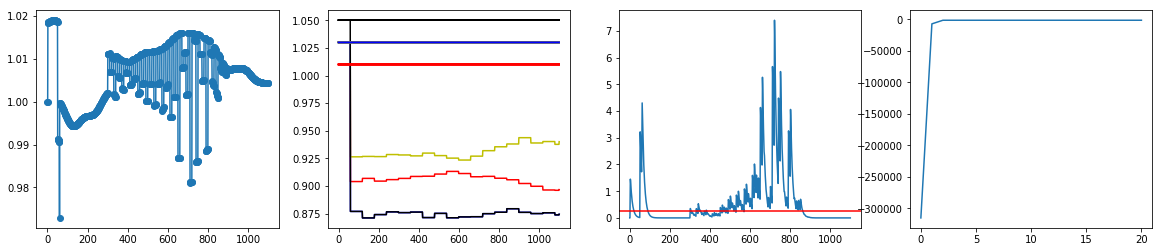

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.013962745666503906 seconds ---
--- 0.016954421997070312 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.0169525146484375 seconds ---
--- 0.014958858489990234 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.012963533401489258 seconds ---
--- 0.013967514038085938 seconds ---
--- 0.013962268829345703 seconds ---
--- 0.016953229904174805 seconds ---
--- 0.013962030410766602 seconds ---
--- 0.013961553573608398 seconds ---
--- 0.012964963912963867 seconds ---


In [ ]:
totalPoints = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
############################################
########### INIT FOR AGENT #################
############################################

#init action
oldAction = []
action = []

#init state
oldState = []
state = []

#init reward
reward = None

mb_state=[]
mb_action=[]
mb_reward=[]
mb_nextstate=[]
buffer = ReplayBuffer(300)
BATCH_SIZE = 30

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(4), sigma=0.3, theta=.1, dt=1e-2)
epsilon = 1
EXPLORE = 144100

for ep in range(50):
    Load = Origin_Load.copy()
    Generation = Origin_Generation.copy()
    #this is for permutate the Load and Generation profile on each node
    #Load = np.random.permutation(Load.T).T
    #Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(7,8))    
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    terminal = False
    
    for timeStep in range(TotalTimeSteps):
        epsilon -= 1/EXPLORE
        
        VBPcounter = [x+1 for x in VBPcounter] 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1
                            
                        #get State
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            if VBPcounter[node-offset] == Delay_VBPCurveShift[node] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[node]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    length = VBPcounter[node-offset]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    
                                oldState = state
                                state = processing_state(V,G,L)
                                #reset VBPcounter
                                VBPcounter[node-offset] = 0
                                #store action                        
                                oldAction = copy.deepcopy(action)
                                
                                #get Action from Agent
                                action = agent.action_respond(state.reshape((1,60,3)))
                                action += noise() * max(epsilon, 0)
                                #apply strict boundary
                                if action[1] < action[0]:
                                    action[0] = action[1]
                                if action[3] < action[2]:
                                    action[2] = action[3]
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(action*0.1 + 1)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points[node-offset] += reward
                                
                                
                                if oldAction != [] and oldState != []:
                                    if terminal: 
                                        ter = 1
                                    else:
                                        ter = 0
                                    buffer.add(oldState.reshape((60,3)), oldAction, np.array([reward]), np.array([ter]), state.reshape((60,3)))
                                
                                if buffer.size() > BATCH_SIZE:
                                    batch = {}
                                    mb_state, mb_action, mb_reward, mb_ter, mb_nextstate = buffer.sample_batch(BATCH_SIZE)
                                    batch['observations'] = mb_state
                                    batch['actions'] = mb_action
                                    batch['rewards'] = mb_reward
                                    batch['next_observations'] = mb_nextstate
                                    batch['rewards'] = mb_reward
                                    batch['terminals'] = mb_ter
                                    start_time_train = time.time()
                                    agent.do_training(batch)
                                    print("--- %s seconds ---" % (time.time() - start_time_train))
                        #################################################                        
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]

    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(7,8):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints[7-offset])
    plt.show(block=True)
    f.savefig(str(ep) + '.png')
